Project of Advanced Artificial Intelligence course - Extracting independence from medical dataset and building Bayesian model

Student name: Madina Kudaibergenova

Project: Building BN for medical dataset

In [1]:
# please, before running the code below, install and restart the notebook
# because these frameworks needs to be installed to show plots right
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 6.6MB/s 
     |████████████████████████████████| 4.7MB 34.1MB/s 
     |████████████████████████████████| 317kB 49.7MB/s 
     |████████████████████████████████| 911kB 9.9MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 8.0MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=3af759dda6f8676e6cb08273874b43f82bf2ed83893ad99989e98d3790e53919
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


# 1. Removing unlabeled data

In [ ]:
# due to that I used Google colab and to read data (and keep it) from drive 
# I called these functions below; however, please, change them if necessary
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing necessary library
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# also change the data paths to work it properly
# add csv files into drive folder and copy the path below
d1 = r"ADD PATH TO FILE/features_all_images.csv"
d2 = r"ADD PATH TO FILE/Labels for data (higher is better).csv"

# reading csv files
df1 = pd.read_csv(d1) 
df2 = pd.read_csv(d2)

# variables to store list of patientID to search for labeled ones
patient1 = set(df1['patient'].values.tolist()) 
patient2 = set(df2['patientId'].values.tolist())

# find intersection in both datasets (labeled and unlabeled)
sim_patients = patient1.intersection(patient2)

In [ ]:
# sort patientIDs for convenience
df1.sort_values(by='patient')
df2.sort_values(by='patientId')
iseq = df2['patientId'] == df1[:len(df2)]['patient']
csv = pd.DataFrame(df2[iseq])

In [ ]:
# resulting dataset of labeled patients with 86 features
df_similar = df1[df1.patient.isin(df2.patientId)]
df_similar

,patient,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
12,002cb550-2e31-42f1-a29d-fbc279977e71,70.0,154.0,777435622,2.392822,50.00,2.279381,224,26.313041,112.252913,112.0,36,188,20.567341,116.536894,-0.020730,777435622,0.208052,980.131161,17.722974,4.015450,99.570841,-0.121880,6.570863,0.174366,0.948291,0.166191,0.662143,0.146115,0.150191,3.186937,-0.667162,0.978892,0.917719,0.997331,0.918169,0.981623,0.159947,0.216009,2.994241,...,7.242822,0.102877,6.178245,1168.111893,0.116342,0.171150,51.105194,0.299401,5.862145,0.029573,97.572491,0.181362,2.312036,18.927509,3.822714e+05,6.702134e+06,29909.041287,0.120562,65.070632,0.120949,0.343676,6.803433,0.035853,6.414995,0.009398,3.709497e+05,4.578160,17973.498419,0.313975,3.180189,11909.963088,1.691105,17.905075,61.409258,1102.653227,5.895837,0.097635,0.026138,0.485036,0.002595
14,00322d4d-1c29-4943-afc9-b6754be640eb,77.0,183.0,1682698356,2.629412,63.00,2.002924,212,32.853314,129.435272,129.0,45,167,25.674058,135.104760,0.037325,1682698356,0.171070,1499.806438,24.394307,4.690509,196.159884,2.166485,9.715904,0.142257,0.971135,0.141923,0.587199,0.121545,0.127487,3.331370,-0.731474,0.989066,0.929072,0.997812,0.929094,0.984234,0.141631,0.174264,3.187592,...,6.951853,0.072268,6.619371,1169.934978,0.083558,0.147975,52.830926,0.210109,4.631952,0.016775,84.753846,0.162988,3.140592,20.523077,9.948953e+05,2.443704e+07

# 2. Choosing uncorrelated data

In [ ]:
# find a pairwise correlation in the dataset
df_similar_corr = df_similar.corr()
df_similar_corr

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
original_firstorder_10Percentile,1.000000,0.473687,0.720622,-0.635462,-0.616039,0.153060,-0.007629,-0.669274,0.917562,0.920082,0.912919,-0.642341,-0.639894,0.860020,-0.652205,0.720622,0.585583,-0.669476,0.033443,0.144609,-0.652386,-0.674631,-0.663605,-0.480236,-0.447698,-0.487728,-0.491776,-0.482106,0.591847,-0.640055,-0.115844,-0.484664,0.488778,-0.214067,0.489241,0.207872,-0.491023,0.477807,-0.640665,-0.664368,...,-0.019897,-0.253294,-0.087089,-0.389641,-0.435162,-0.489282,0.452213,-0.362437,-0.341468,-0.274869,0.018524,0.597668,-0.694465,-0.224146,0.490927,0.545938,-0.000255,-0.257426,-0.341284,-0.197951,-0.216173,-0.255880,-0.306046,-0.345841,-0.322453,0.495156,-0.625297,0.378910,0.491977,-0.498375,0.458826,-0.667981,0.023812,0.488724,0.142819,-0.405826,-0.442606,-0.484336,-0.228313,-0.502369
original_firstorder_90Percentile,0.473687,1.000000,0.779636,0.344881,0.352313,-0.108376,0.750952,0.328364,0.759191,0.687247,0.369481,0.226410,0.342969,0.837415,-0.290133,0.779636,-0.350102,0.317435,0.602192,0.596804,0.255787,-0.121896,0.324890,0.116107,0.350459,0.119285,0.117602,0.116110,-0.320035,0.309862,-0.160139,0.348804,-0.119790,0.239575,-0.120073,0.040533,0.121208,-0.364778,0.320863,0.324240,...,-0.277187,-0.397396,0.216657,0.090547,-0.022971,0.120053,-0.119876,-0.146856,0.332572,

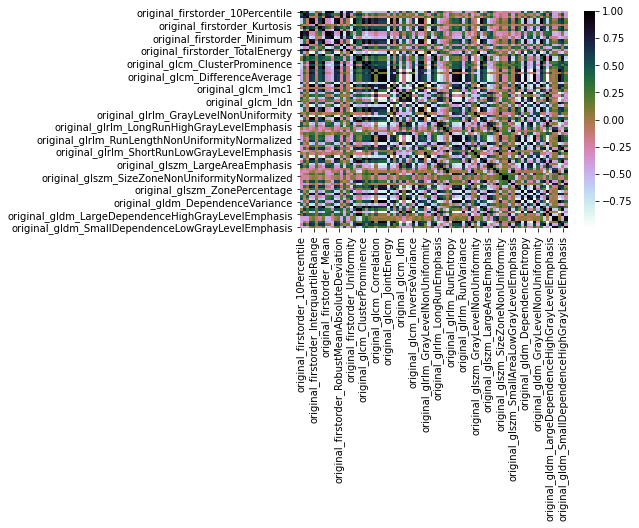

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# drawing correlation matrix
colormap = plt.cm.cubehelix_r
sn.heatmap(df_similar_corr, annot=False, cmap=colormap)
plt.figure(figsize=(15,15))
plt.show()

In [ ]:
# import library to filter dataset
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# removing constant features with 0 variance
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(df_similar_corr)

VarianceThreshold(threshold=0)

In [ ]:
# see if there is any constant variables in our dataset
constant_columns = [column for column in df_similar_corr.columns
                    if column not in df_similar_corr.columns[constant_filter.get_support()]]

print(len(constant_columns))

0


In [ ]:
# find duplicates 
print(df_similar_corr.T.duplicated().sum())

1


In [ ]:
# drop duplicates
unique_features = df_similar_corr.T.drop_duplicates(keep='first').T

In [ ]:
duplicated_features = [dup_col for dup_col in df_similar_corr.columns if dup_col not in unique_features.columns]
duplicated_features

['original_firstorder_TotalEnergy']

In [ ]:
# removing correlated features
correlated_features = set()
for i in range(len(df_similar_corr.columns)):
    for j in range(i):
        if abs(df_similar_corr.iloc[i, j]) > 0.8:
            colname = df_similar_corr.columns[i]
            correlated_features.add(colname)

In [ ]:
len(correlated_features)

67

In [ ]:
print(correlated_features)

{'original_glcm_ClusterShade', 'original_gldm_LowGrayLevelEmphasis', 'original_firstorder_TotalEnergy', 'original_glszm_LargeAreaEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage', 'original_firstorder_Range', 'original_gldm_DependenceVariance', 'original_glcm_JointAverage', 'original_firstorder_InterquartileRange', 'original_glrlm_RunEntropy', 'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_glrlm_HighGrayLevelRunEmphasis', 'original_gldm_DependenceEntropy', 'original_glcm_ClusterProminence', 'original_glcm_Idm', 'original_glcm_Id', 'original_glrlm_GrayLevelVariance', 'original_firstorder_Uniformity', 'original_glcm_SumEntropy', 'original_glrlm_RunPercentage', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glcm_JointEnergy', 'original_firstorder_MeanAbsoluteDeviation', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glcm_SumSquares', 'original_glsz

In [ ]:
# drop correlated features
df_similar.drop(labels=correlated_features, axis=1, inplace=True)
df_similar

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,patient,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Skewness,original_glcm_Autocorrelation,original_glcm_Contrast,original_glcm_Correlation,original_glcm_Imc1,original_glcm_Idmn,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_gldm_DependenceNonUniformity,original_gldm_GrayLevelNonUniformity
12,002cb550-2e31-42f1-a29d-fbc279977e71,70.0,154.0,777435622,2.392822,2.279381,224,-0.020730,17.722974,0.174366,0.948291,-0.667162,0.997331,1976.163614,1786.934854,7.242822,65.070632,0.120949,17973.498419,11909.963088
14,00322d4d-1c29-4943-afc9-b6754be640eb,77.0,183.0,1682698356,2.629412,2.002924,212,0.037325,24.394307,0.142257,0.971135,-0.731474,0.997812,2469.556517,2757.115416,6.951853,81.403846,0.156546,32050.221769,15770.294383
19,00569f44-917d-4c86-a842-81832af98c30,54.0,128.0,736631943,2.197042,2.392698,166,-0.006951,18.529831,0.136156,0.945901,-0.688571,0.997277,2722.761465,2698.209304,8.809891,169.311054,0.217623,29694.325229,19652.423983
24,00704310-78a8-4b38-8475-49f4573b2dbb,35.0,166.0,635821335,2.830877,2.027442,200,0.441069,21.185030,0.150091,0.980303,-0.740768,0.998170,1426.440932,2246.343999,11.399698,79.660592,0.181459,19424.150355,9084.668241
25,0087bd3a-55a7-4045-b111-b018fa52d361,62.0,135.0,653176703,2.159018,2.117314,162,0.068940,12.792497,0.070676,0.971364,-0.804265,0.998090,1168.593682,5627.795202,48.497949,55.231405,0.228229,37450.690612,15534.361813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26647,ffad4160-d78e-4bcc-ab1f-47e20e613bd6,17.0,149.0,489660463,2.831061,1.806971,198,0.292194,17.255182,0.144892,0.982563,-0.751532,0.997777,1192.422259,2049.410857,39.497129,63.186186,0.189748,20303.115117,8359.353349
26663,ffd670a5-b6dc-4f54-928a-69b7a04662eb,60.0,143.0,711482369,2.336608,2.268465,164,-0.137764,22.357496,0.114673,0.962636,-0.739330,0.997707,1623.534248,3818.200703,9.637197,44.485714,0.141224,26687.712944,13824.428445
26664,ffd787b6-59ca-48cb-bd15-bcedd52cf37c,74.0,141.0,994239417,2.085468,2.644035,169,-0.028147,15.487759,0.060754,0.971654,-0.820591,0.998358,1379.837552,9618.541778,45.749986,49.925000,0.208021,51298.558289,22381.944124
26683,fffcff11-d018-4414-971a-a7cefa327795,33.0,168.0,860743826,2.919786,1.836263,209,0.120638,23.465730,0.143211,0.982519,-0.756175,0.998255,1514.758266,2946.347301,13.786015,88.913607,0.192038,24993.041729,9871.123980


# 3. Merging labels with features

In [ ]:
# choose target algorithm with highest score
df2['maxAccuracy'] = df2[['chexnet','resnet','unet','cnn']].max(axis=1)
df2['algorithm'] = df2[['chexnet','resnet','unet','cnn']].idxmax(axis=1)

In [ ]:
# delete unnecessary columns
df2.pop('chexnet')
df2.pop('resnet')
df2.pop('unet')
df2.pop('cnn')

0       0.618319
1       0.000584
2       1.000000
3       0.000260
4       0.740208
          ...   
2495    1.000000
2496    1.000000
2497    0.623503
2498    0.000311
2499    1.000000
Name: cnn, Length: 2500, dtype: float64

In [ ]:
# our dataset with labeled data
df2

,patientId,maxAccuracy,algorithm
0,002cb550-2e31-42f1-a29d-fbc279977e71,0.618319,cnn
1,00322d4d-1c29-4943-afc9-b6754be640eb,1.000000,resnet
2,00569f44-917d-4c86-a842-81832af98c30,1.000000,chexnet
3,00704310-78a8-4b38-8475-49f4573b2dbb,0.000417,resnet
4,0087bd3a-55a7-4045-b111-b018fa52d361,0.740208,cnn
...,...,...,...
2495,ffad4160-d78e-4bcc-ab1f-47e20e613bd6,1.000000,chexnet
2496,ffd670a5-b6dc-4f54-928a-69b7a04662eb,1.000000,chexnet
2497,ffd787b6-59ca-48cb-bd15-bcedd52cf37c,0.645755,chexnet
2498,fffcff11-d018-4414-971a-a7cefa327795,1.000000,chexnet


In [ ]:
# create new dataframe
new = df2[['maxAccuracy','algorithm']].copy()
new

,maxAccuracy,algorithm
0,0.618319,cnn
1,1.000000,resnet
2,1.000000,chexnet
3,0.000417,resnet
4,0.740208,cnn
...,...,...
2495,1.000000,chexnet
2496,1.000000,chexnet
2497,0.645755,chexnet
2498,1.000000,chexnet


In [ ]:
# copying columns
df_similar[['maxA','algo']] = df2[['maxAccuracy','algorithm']].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
df_similar

,patient,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Skewness,original_glcm_Autocorrelation,original_glcm_Contrast,original_glcm_Correlation,original_glcm_Imc1,original_glcm_Idmn,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_gldm_DependenceNonUniformity,original_gldm_GrayLevelNonUniformity,maxA,algo
12,002cb550-2e31-42f1-a29d-fbc279977e71,70.0,154.0,777435622,2.392822,2.279381,224,-0.020730,17.722974,0.174366,0.948291,-0.667162,0.997331,1976.163614,1786.934854,7.242822,65.070632,0.120949,17973.498419,11909.963088,0.618319,cnn
14,00322d4d-1c29-4943-afc9-b6754be640eb,77.0,183.0,1682698356,2.629412,2.002924,212,0.037325,24.394307,0.142257,0.971135,-0.731474,0.997812,2469.556517,2757.115416,6.951853,81.403846,0.156546,32050.221769,15770.294383,1.000000,resnet
19,00569f44-917d-4c86-a842-81832af98c30,54.0,128.0,736631943,2.197042,2.392698,166,-0.006951,18.529831,0.136156,0.945901,-0.688571,0.997277,2722.761465,2698.209304,8.809891,169.311054,0.217623,29694.325229,19652.423983,1.000000,chexnet
24,00704310-78a8-4b38-8475-49f4573b2dbb,35.0,166.0,635821335,2.830877,2.027442,200,0.441069,21.185030,0.150091,0.980303,-0.740768,0.998170,1426.440932,2246.343999,11.399698,79.660592,0.181459,19424.150355,9084.668241,0.000417,resnet
25,0087bd3a-55a7-4045-b111-b018fa52d361,62.0,135.0,653176703,2.159018,2.117314,162,0.068940,12.792497,0.070676,0.971364,-0.804265,0.998090,1168.593682,5627.795202,48.497949,55.231405,0.228229,37450.690612,15534.361813,0.740208,cnn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26647,ffad4160-d78e-4bcc-ab1f-47e20e613bd6,17.0,149.0,489660463,2.831061,1.806971,198,0.292194,17.255182,0.144892,0.982563,-0.751532,0.997777,1192.422259,2049.410857,39.497129,63.186186,0.189748,20303.115117,8359.353349,1.000000,chexnet
26663,ffd670a5-b6dc-4f54-928a-69b7a04662eb,60.0,143.0,711482369,2.336608,2.268465,164,-0.137764,22.357496,0.114673,0.962636,-0.739330,0.997707,1623.534248,3818.200703,9.637197,44.485714,0.141224,26687.712944,13824.428445,1.000000,chexnet
26664,ffd787b6-59ca-48cb-bd15-bcedd52cf37c,74.0,141.0,994239417,2.085468,2.644035,169,-0.028147,15.487759,0.060754,0.971654,-0.820591,0.998358,1379.837552,9618.541778,45.749986,49.925000,0.208021,51298.558289,22381.944124,0.645755,chexnet
26683,fffcff11-d018-4414-971a-a7cefa327795,33.0,168.0,860743826,2.919786,1.836263,209,0.120638,23.465730,0.143211,0.982519,-0.756175,0.998255,1514.758266,2946.347301,13.786015,88.913607,0.192038,24993.041729,9871.123980,1.000000,chexnet


In [ ]:
# save results to new csv file - not necessary
df_similar.to_csv('results.csv')

# 4. Naive Bayes Classification

In [ ]:
# import libraries
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Convert categorical variable to numeric
df_similar['algo_cleaned']=np.where(df_similar['maxA']==1,1,0)

# Split dataset in training and test datasets
X_train, X_test = train_test_split(df_similar, test_size=0.5, random_state=int(time.time()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Instantiate the classifier
gnb = GaussianNB()
used_features =[
    'original_firstorder_10Percentile',
    'original_firstorder_90Percentile',
    'original_firstorder_Energy',
    'original_firstorder_Entropy',
    'original_firstorder_Kurtosis',
    'original_firstorder_Maximum',
    'original_firstorder_Skewness',
    'original_glcm_Autocorrelation',
    'original_glcm_Contrast',
    'original_glcm_Correlation',
    'original_glcm_Imc1',
    'original_glcm_Idmn',
    'original_glrlm_GrayLevelNonUniformity',
    'original_glrlm_LongRunHighGrayLevelEmphasis',
    'original_glrlm_LongRunLowGrayLevelEmphasis',
    'original_glszm_SizeZoneNonUniformity',
    'original_glszm_SizeZoneNonUniformityNormalized',
    'original_gldm_DependenceNonUniformity',
    'original_gldm_GrayLevelNonUniformity',
    'algo_cleaned'
]

# Train classifier
gnb.fit(
    X_train[used_features].values,
    X_train["algo_cleaned"]
)
y_pred = gnb.predict(X_test[used_features])

# Print results
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["algo_cleaned"] != y_pred).sum(),
          100*(1-(X_test["algo_cleaned"] != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 1250 points : 341, performance 72.72%


In [ ]:
# apply  classifier on train data
mean_algo=np.mean(X_train["algo_cleaned"])
mean_not_algo=1-mean_algo
print("Correct algo prob = {:03.2f}%, Not correct algo prob = {:03.2f}%"
      .format(100*mean_algo,100*mean_not_algo))

Correct algo prob = 70.88%, Not correct algo prob = 29.12%


In [ ]:
# find probability distributions P(original_firstorder_10Percentile | algo = 0) and P(original_firstorder_10Percentile | algo = 1)
# mean and std values
mean_patient_algo = np.mean(X_train[X_train["algo_cleaned"]==1]["original_firstorder_10Percentile"])
std_patient_algo = np.std(X_train[X_train["algo_cleaned"]==1]["original_firstorder_10Percentile"])
mean_patient_not_algo = np.mean(X_train[X_train["algo_cleaned"]==0]["original_firstorder_10Percentile"])
std_patient_not_algo = np.std(X_train[X_train["algo_cleaned"]==0]["original_firstorder_10Percentile"])

print("mean_patient_algo = {:03.2f}".format(mean_patient_algo))
print("std_patient_algo = {:03.2f}".format(std_patient_algo))
print("mean_patient_not_algo = {:03.2f}".format(mean_patient_not_algo))
print("std_patient_not_algo = {:03.2f}".format(std_patient_not_algo))

mean_patient_algo = 53.96
std_patient_algo = 24.86
mean_patient_not_algo = 71.14
std_patient_not_algo = 26.16


In [ ]:
# histogram
gnb = GaussianNB()
used_features =["original_firstorder_10Percentile"]
y_pred = gnb.fit(X_train[used_features].values, X_train["algo_cleaned"]).predict(X_test[used_features])
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["algo_cleaned"] != y_pred).sum(),
          100*(1-(X_test["algo_cleaned"] != y_pred).sum()/X_test.shape[0])
))
print("Std original_firstorder_10Percentile not_algo: {:05.2f}".format(np.sqrt(gnb.sigma_)[0][0]))
print("Std original_firstorder_10Percentile algo: {:05.2f}".format(np.sqrt(gnb.sigma_)[1][0]))
print("Mean original_firstorder_10Percentile not_algo {:05.2f}".format(gnb.theta_[0][0]))
print("Mean original_firstorder_10Percentile algo: {:05.2f}".format(gnb.theta_[1][0]))

Number of mislabeled points out of a total 1250 points : 351, performance 71.92%
Std original_firstorder_10Percentile not_algo: 26.16
Std original_firstorder_10Percentile algo: 24.86
Mean original_firstorder_10Percentile not_algo 71.14
Mean original_firstorder_10Percentile algo: 53.96


# 5. Analysing and Building BN

In [ ]:
# import libraries
from scipy import stats
import arviz as az
import pymc3 as pm
from theano import shared
from sklearn import preprocessing

In [ ]:
# check if there is any missing data
df_similar.isnull().sum()/len(df_similar)

patient                                           0.0
original_firstorder_10Percentile                  0.0
original_firstorder_90Percentile                  0.0
original_firstorder_Energy                        0.0
original_firstorder_Entropy                       0.0
original_firstorder_Kurtosis                      0.0
original_firstorder_Maximum                       0.0
original_firstorder_Skewness                      0.0
original_glcm_Autocorrelation                     0.0
original_glcm_Contrast                            0.0
original_glcm_Correlation                         0.0
original_glcm_Imc1                                0.0
original_glcm_Idmn                                0.0
original_glrlm_GrayLevelNonUniformity             0.0
original_glrlm_LongRunHighGrayLevelEmphasis       0.0
original_glrlm_LongRunLowGrayLevelEmphasis        0.0
original_glszm_SizeZoneNonUniformity              0.0
original_glszm_SizeZoneNonUniformityNormalized    0.0
original_gldm_DependenceNonU

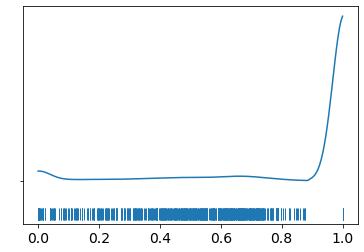

In [ ]:
# Gaussian inference
# KDE plot pf the kurtosis shows a Gaussian-like distribution
az.plot_kde(df_similar['maxA'].values, rug=True)
plt.yticks([0], alpha=0);

In [ ]:
# actual mean
print(np.mean(df_similar['maxA']))

0.8219529919990589


In [ ]:
# build Model and sample
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=200)
    σ = pm.HalfNormal('σ', sd=58.8)
    # y - is log-likelyhood
    y = pm.Normal('y', mu=μ, sd=σ, 
      observed=df_similar['original_firstorder_10Percentile'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1365.42it/s]


/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

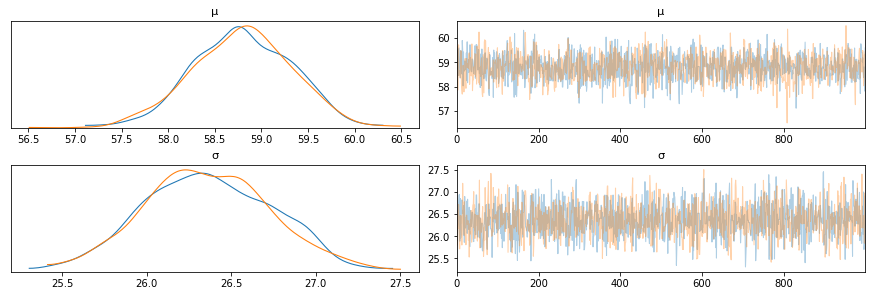

In [ ]:
# KDE plot and sampled plot
az.plot_trace(trace_g);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3fbecdbd0>,
      dtype=object)

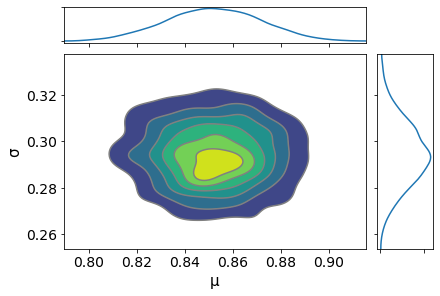

In [ ]:
# plotting joint distributions of parameters
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [ ]:
# Posterior Predictive Checks
# randomly draw 1000 samples of parameters from the trace, and for each sample it will draw 231 random numbers
# from a normal distribution specified by the values of mu and std in that sample
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model = model_g)
np.asarray(ppc['y']).shape

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 664.51it/s]


(1000, 2500)

[Text(0.5, 1.0, 'Posterior predictive of the mean'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'Frequency')]

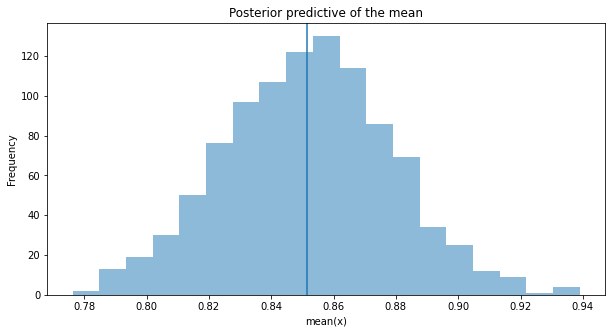

In [ ]:
_, ax = plt.subplots(figsize=(10,5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(res_dfs_and_df2.maxAccuracy.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel = 'Frequency')